In [15]:
import os
import json
import hoomd
import codecs
import cooltools

import numpy as np
import matplotlib.pyplot as plt

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render
import polychrom_hoomd.extrude as extrude

from polykit.analysis import polymer_analyses, contact_maps
from polykit.analysis.polymer_analyses import Rg2
from polykit.generators.initial_conformations import grow_cubic

import gsd
import numpy as np
import pandas as pd
import time
from polychrom_hoomd.utils import unwrap_coordinates

In [16]:
device = hoomd.device.GPU(notice_level=3, gpu_ids=[0])

In [17]:
def simulate(density=0.2, chromosome_sizes=[15000], dpd=False, contact_list=[]):

    rng_seed = os.urandom(2)
    rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)
    system = hoomd.Simulation(device=device, seed=rng_seed)

    number_of_monomers = sum(chromosome_sizes)
    L = (number_of_monomers/density) ** (1/3.)
    
    snapshot = build.get_simulation_box(box_length=L)
    
    # Build random, dense initial conformations
    monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(L-2))

    # schic bonds
    with open("force_dict_schic.json", 'r') as dict_file:
        force_dict = json.load(dict_file)
    bond_types = force_dict['Bonded forces'].keys()
    
    # Populate snapshot with the generated chains
    build.set_chains(snapshot, monomer_positions, chromosome_sizes, monomer_type_list=['A'], bond_type_list=list(bond_types))
    
    # Setup HooMD simulation object
    system.create_state_from_snapshot(snapshot)
    # system.operations.writers.append(
    #     hoomd.write.CustomWriter(action=RGWriter('hoomd'), trigger=1000)
    # )
    
    # Setup neighbor list
    nl = hoomd.md.nlist.Cell(buffer=0.4)
    
    # Read input force parameters
    json.dumps(force_dict, indent=4, sort_keys=True)
    
    # Set chromosome excluded volume
    repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)
    
    # Set bonded/angular potentials
    bonded_forces = forces.get_bonded_forces(**force_dict)
    angular_forces = forces.get_angular_forces(**force_dict)

    # set contact forces
    extrude.update_topology(system, contact_list)
    
    # Define full force_field
    force_field = repulsion_forces + bonded_forces + angular_forces
    if dpd:
        # Set a pseudo square well attraction force acting on B-type monomers
        force_dict["Non-bonded forces"]["Attraction"] = {
            "Cutoff": 1.5,
            "Matrix": {
                "A": {
                    "A": 0,
                    "B": 0
                },
                "B": {
                    "A": 0,
                    "B": 0.2
                }
            },
            "Type": "Polychrom"
        }
        dpd_forces = forces.get_dpd_forces(nl, **force_dict)
        attraction_forces = forces.get_attraction_forces(nl, **force_dict)
        force_field += dpd_forces

        # system.operations.remove(system.operations.writers[0])
        nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
        dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)
        system.operations.integrator = dpd_integrator
    else:
        # HooMD to openMM time conversion factor
        t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5
        
        # Initialize integrators and Langevin thermostat
        langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
        integrator = hoomd.md.Integrator(dt=70*t_conv, methods=[langevin], forces=force_field)
        
        # Setup log and simulation engines
        logger = log.get_logger(system)
        
        system.operations.integrator = integrator

    
    # system.operations.writers.append(log.table_formatter(logger, period=1e4))

    gsd_writer = hoomd.write.GSD(filename='trajectory.gsd',
                                 trigger=hoomd.trigger.Periodic(1000),
                                 dynamic=['topology'],
                                 mode='wb')
    
    system.operations.writers.append(gsd_writer)
    
    system.run(6e5)
    snapshot_relaxed = system.state.get_snapshot()
    return snapshot_relaxed

In [18]:
contacts = np.array(pd.read_csv("edges_round0.csv", index_col=0))
chrom_sizes = list(pd.read_csv("chrom-sizes.csv").length)

In [19]:
start_time = time.time()
snap = simulate(chromosome_sizes=chrom_sizes, dpd=True, contact_list=contacts)
end_time = time.time()
print(f"Computations time: {end_time-start_time}s")

Setting up DPD with the conservative force contribution disabled


/home/baneckik/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


notice(3): GSD: create or overwrite gsd file trajectory.gsd
Computations time: 70.1092803478241s


In [20]:
trajectory = gsd.hoomd.open('trajectory.gsd', 'r')
rg2 = np.zeros(len(trajectory))

for i, snap in enumerate(trajectory):
    positions = unwrap_coordinates(snap)
    rg2[i] = polymer_analyses.Rg2(positions)

INFO:gsd.fl:opening file: trajectory.gsd with mode: r
INFO:gsd.hoomd:opening HOOMDTrajectory: <gsd.fl.GSDFile object at 0x55f30130ec00>
INFO:gsd.hoomd:found 600 frames


In [61]:
# np.save("./hoomd_model_round0.npy", positions)

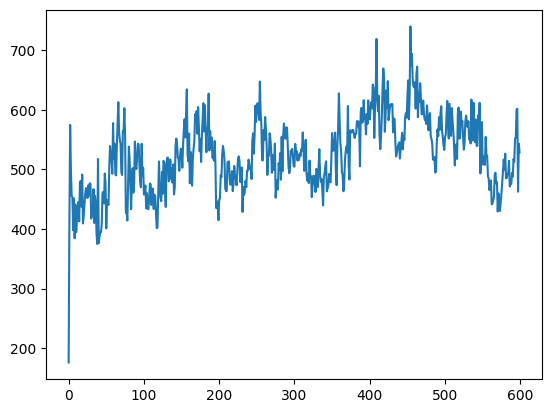

In [21]:
plt.plot(rg2)
plt.show()

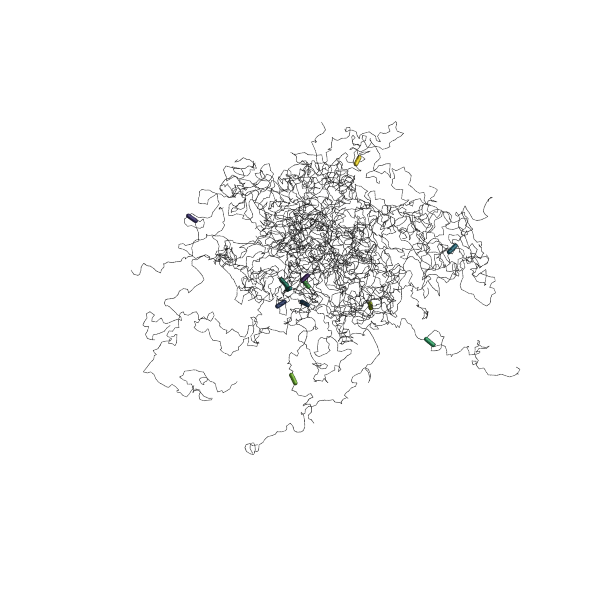

In [22]:
# Visualize new extrusion bonds 
render.fresnel(snap, show_loops=True, rescale_backbone_bonds=0.1).static()